# Part 2: PCA

In [1]:
import os
import os.path as op
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

## Loading and choosing the right data 

In [2]:
# Remove the next cell after making only one notebook

In [3]:
dataset_id = 'ds000171'
subject = 'control01' 

sample_path = "/home/jovyan/Data/dataset"
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

Before applying the PCA to the fMRI data, we need to preprocessit. However, the preprocessing steps have already been done above. Therefore, we can reuse the already obtained preprocessed runs. We decided to keep the smoothing step in order to improve the signal to noise ratio of the data that the PCA will be run on.

In [4]:
data_path = op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco_smoothed-6mm.nii.gz')
img_anat = nib.load(op.join(preproc_root, 'sub-control01', 'anat','coregistered_anatomical.nii.gz'))
img = nib.load(data_path)
affine = img.affine
data = np.asanyarray(img.dataobj)
data.shape

(80, 80, 50, 315)

## Preprocessing

Since the PCA is meant to track the evolution of the data over time, the samples are timepoints and the voxels are seen as features. 

In [5]:
vol_shape = data.shape[0:3]
n_vols = data.shape[3]

num_zero_values_after = np.sum(data == 0)
print(f"Number of zero values after standardization: {num_zero_values_after}")

Number of zero values after standardization: 62814988


As we can see from the output of the previous cell, there is a great number of voxels with a null value. They correspond to the background, and were added at the end of the preprocessing step by applying a mask. In order to continue, we need to get rid of them since they are irrelevant for the PCA: they contain no data influenced by the experiment at hand.

In [6]:
# Removing background
slice_non_background = np.ones(vol_shape, dtype=bool) # intialize a mask to keep track of non-background voxels
samples = data[slice_non_background, :]
print('original shape:', samples.shape)

for vol in range(n_vols):
    slice_non_background &= (data[:, :, :, vol] != 0) # use AND with every voxel in every volume to update mask

samples = data[slice_non_background, :] ## shape should be (n_voxels, n_timepoints) for PCA
print('shape after removing background', samples.shape)

if np.any(samples == 0):
    print("Warning: There are still zero values in the samples array!")


original shape: (320000, 315)
shape after removing background (112268, 315)


Removing the spatial mean across timepoints from each timepoints. Calculates the mean spatial pattern and perform the substraction operation.
# Why is the row mean not used (Does the substracion give the same thing without the row copying) ? Is the spatial mean correct ? Because the row is the same as in the series, but our dimentions are reversed.

In [10]:
# Calculate the mean across columns
spatial_means = np.mean(samples, axis=1) # shape (1, n_timepoints)

# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = np.outer(spatial_means, np.ones(n_vols))

# Subtract the means for each row, put the result into X
X = samples - row_means

# Verify that the spatial mean behaves as expected after substraction
# Calculate the mean across time for each voxel to chek if its close to zero 
verification_means = np.mean(X, axis=-1)

# Print verification result
print("Verification (should be close to zero): \n", np.round(verification_means, decimals=4))

Verification (should be close to zero): 
 [-0. -0. -0. ...  0. -0.  0.]


As we can see from the output of the previous cell, the values of the row-wise mean of the X matrix are close to zero. This means that our centering worked. Indeed, by subtracting the mean for each voxel across all time points, we make the time series of each voxel have an average value of zero, which is what we see here. What is left is to check weather the X matrix has the right shape.

In [11]:
X.shape

(112268, 315)

Which is the case: is has the same shape as the samples matrix after the removal of the zero voxels.

# Components extraction

Now we can move on to the extraction of components. In the next cell we run the PCA. There is no need to run it on the transpose of the X matrix, since it already has the right dimensions.

In [17]:
from sklearn.decomposition import PCA
nb_components = 20 # Arbitrary number

pca = PCA(n_components=nb_components)

# Fit the PCA model to the data (where samples are voxels and features are time points)
pca.fit(X.T)

# Retrieve the principal components
components = pca.components_  # Shape (nb_components, n_timepoints)
explained_variance = pca.explained_variance_ratio_

print("Explained variance by each component:", explained_variance)
print("Components shape:", components.shape)

Explained variance by each component: [0.68969005 0.12960934 0.04022598 0.01399176 0.01178557 0.00835731
 0.00695516 0.00643317 0.00493513 0.00464428 0.0040836  0.00389403
 0.00312108 0.00286632 0.00275322 0.00233823 0.00211379 0.00183638
 0.00162903 0.0015011 ]
Components shape: (20, 112268)


Now we must chose a number of components that will explain a sufficient amount of variance. We know that the bogger an eigenvalue is, the more variance it explains. Therefore, we will sort them and plot sum of the explained variance as a funcion of the first considered eigenvalues.

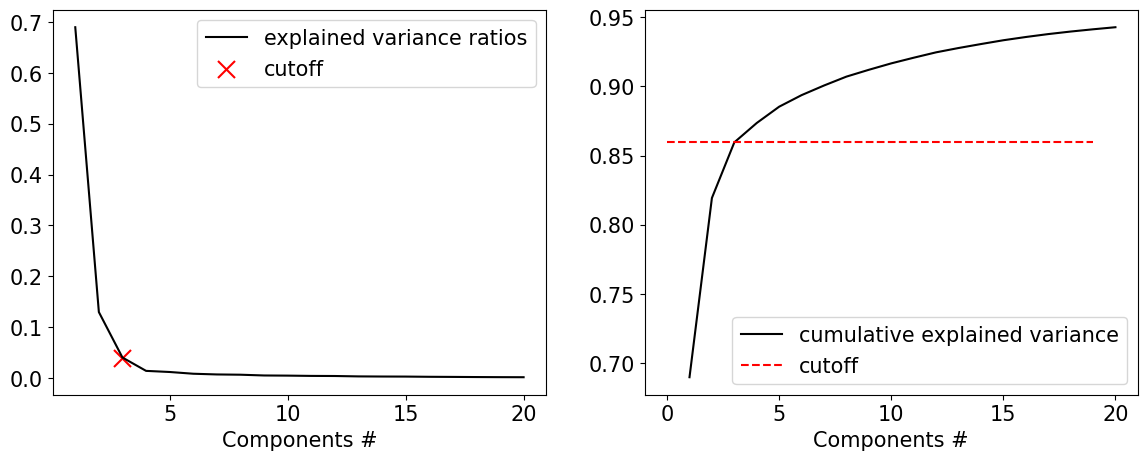

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)
nb_clusters = 3

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

From these graphs, we can see that keeping the first three components explains almost 75% of the total variance. Now, from these three components, we will reconstruct spatial volumes and overlay them onto anatomical data to visualise the parts of the brain that are the most influenced by the notes and songs heard during the fMRI runs.

In [19]:

# Initialize an empty list to store each spatial component as a 3D volume
pca_clusters = []

# For each component, reshape it back to the original spatial shape using the mask
for spatial_component in components:
    # Step 1: Initialize a 3D volume with the original shape, filled with zeros or NaN
    component_volume = np.zeros(vol_shape)  # Or use np.full(vol_shape, np.nan) for NaNs

    # Step 2: Place the values from the component back into the spatial volume
    component_volume[slice_non_background] = spatial_component

    # Step 3: Append the reshaped 3D volume to the list
    pca_clusters.append(component_volume)

# `pca_clusters` now contains reconstructed spatial volumes for each PCA component


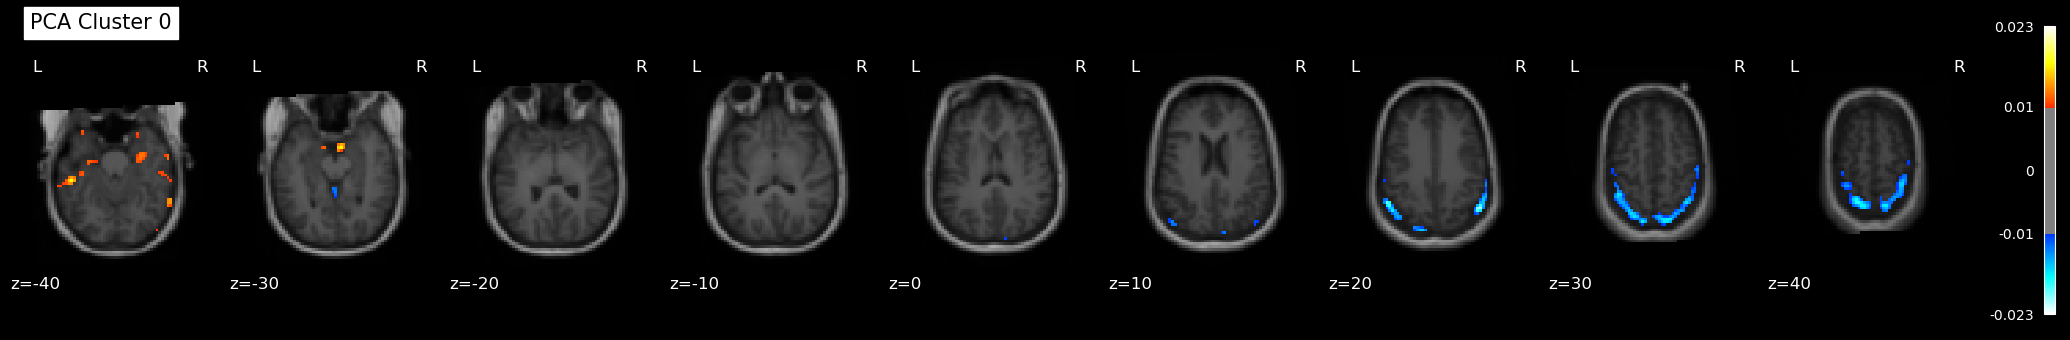

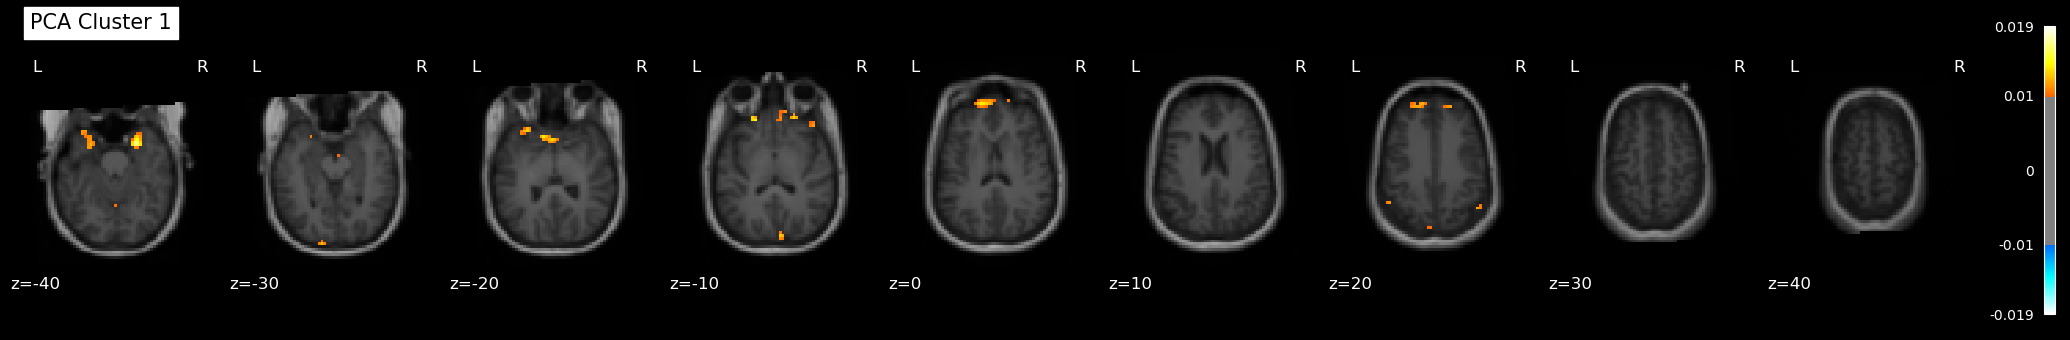

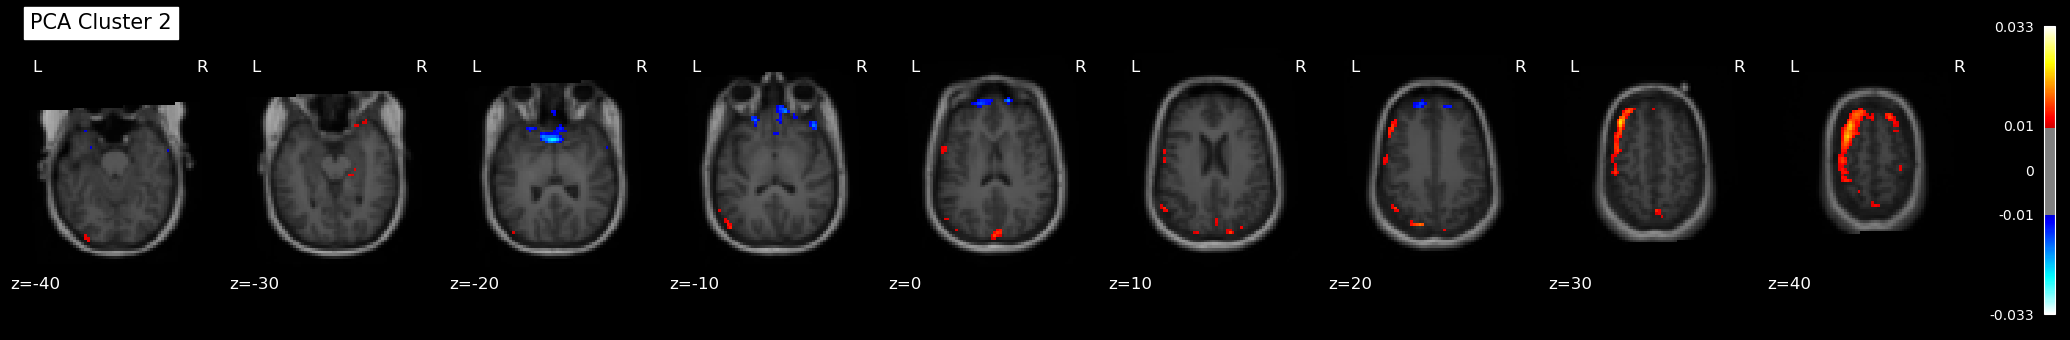

In [20]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img_anat)

for visual_idx in range(nb_clusters):
    plot_stat_map(nib.Nifti1Image(pca_clusters[visual_idx], affine), bg_img=mean_img_, threshold=0.01,
                   cut_coords=[-40, -30, -20, -10, 0, 10, 20, 30, 40], black_bg=True, display_mode = "z",
                  title=f'PCA Cluster {visual_idx}')

plt.show()